In [1]:
GC.gc()

include("src/utils.jl")
include("src/solver.jl")
include("src/loader.jl");

In [2]:
filename = "data/profiles.csv"
YEARS = [2014, 2015, 2016, 2017, 2018]
if ! @isdefined(time_profiles) || issubset(YEARS, keys(time_profiles)) == false
    time_profiles, wind_profiles, solar_profiles = load_profiles(
        filename,
        years = YEARS,
        verbose = true
    )
end;

print("Loaded profiles for years: ", keys(time_profiles), "\n")

Loading the profiles for the year 2014
Loading the profiles for the year 2015
Loading the profiles for the year 2016
Loading the profiles for the year 2017
Loading the profiles for the year 2018
Loaded profiles for years: Any[2018, 2014, 2017, 2016, 2015]


In [3]:
# Default values
DEMAND = 1000. # Kg of H2
# Battery parameters
EBAT = 0.9 # per month discharge
FBAT = 100. # MW
COST_BAT = 250000 * 0.0002 # € / MWh
# Electrolyzer parameters
EELEC = 0.050 # MWh / Kg
COST_ELEC =  1200000 * 0.0004 # € / MW
CAPA_ELEC_UPPER = 1000. # MW
# Tank parameters
COST_TANK = 407. # € / Kg
# Grid parameters
PRICE_GRID = 1000. # € / MWh
PRICE_CURTAILING = 500. # € / MWh;
PRICE_PENALITY = 10 # € / kg of change in the production
# Renewable pricing, from https://atb.nrel.gov/electricity/2022/index
# For now : 20 year lifespan, no discount rate + O&M cost per year
COST_WIND = 1352 * 1000 / 20 + 43 * 1000 # € / MW
COST_SOLAR = 1233 * 1000 / 20 + 23 * 1000 # € / MW
# Upper bound on the battery capacity
CAPA_BAT_UPPER = 6 * DEMAND * EELEC ;# MW

In [4]:
D = 1000.
# Aggregate the 5 years of profiles into a single profile
full_wind_profile :: Vector{Float64} = []
full_solar_profile :: Vector{Float64} = []
full_time_profile :: Vector{DateTime} = []

for year in sort!(collect(keys(wind_profiles)))
    print("Loading year $year \n")
    append!(full_time_profile, time_profiles[year])
    append!(full_wind_profile, wind_profiles[year])
    append!(full_solar_profile, solar_profiles[year])
end

print("Wind profile is of length $(length(full_wind_profile)) \n")
print("Solar profile is of length $(length(full_solar_profile)) \n")
print("5 * 24 * 365 + 24 is $(5 * 24 * 365 + 24) \n")

Loading year 2014 
Loading year 2015 
Loading year 2016 
Loading year 2017 
Loading year 2018 
Wind profile is of length 43824 
Solar profile is of length 43824 
5 * 24 * 365 + 24 is 43824 


In [5]:
# We need to update the annualized cost for the permanent installations
n_years = length(keys(wind_profiles))
cost_elec_n = COST_ELEC * n_years
cost_bat_n = COST_BAT * n_years
cost_tank_n = COST_TANK * n_years
cost_wind_n = COST_WIND * n_years
cost_solar_n = COST_SOLAR * n_years

output = solve(
    wind_profile = full_wind_profile,
    solar_profile = full_solar_profile,
    demand = DEMAND,
    wind_capa = -1,
    solar_capa = -1,
    electro_capa = -1,
    battery_capa = -1,
    tank_capa = -1,
    price_grid = PRICE_GRID,
    price_curtailing = PRICE_CURTAILING,
    price_penality = PRICE_PENALITY,
    cost_wind = cost_wind_n,
    cost_solar = cost_solar_n,
    cost_elec = cost_elec_n,
    cost_bat = cost_bat_n,
    cost_tank = cost_tank_n,
    ebat = EBAT,
    fbat = FBAT,
    eelec = EELEC,
    capa_elec_upper = CAPA_ELEC_UPPER,
    capa_bat_upper = CAPA_BAT_UPPER,
    verbose = true
);

Adding variables ...
Adding constraints ...
Solving the model ...


In [12]:
# Print the solution properties
print_solution_propreties(
    output = output,
    wind = full_wind_profile,
    solar = full_solar_profile,
    time = full_time_profile,
);

Battery capacity: 300.0 MWh, Tank capacity: 50978.844868658445 kg, Electrolyser capacity: 2137.0732551036294 kg/h
Wind capacity: 142.8768712217979 MW, Solar capacity: 193.6597407673006 MW 

Wind proportion in capacity: 0.4245507505924085 
Wind proportion in generation: 0.5955855572801084 

Total electricity needed: 2.1912e6 MWh, Total electricity produced: 2.147878e6 MWh
Total electricity imported: 192783.0 MWh, Total electricity curtailment: 148723.0 MWh 

Produced / Needed ratio : 0.9802290982110259
Curtailed / Produced ratio : 0.06924182844649464 

Storage cost: 1.03816949e8, operating cost: 2.71361331e8
Electrolyser cost : 256448.0, electricity plant cost: 1.60977395e8
Total cost: 5.36412125e8


In [13]:
# Get the plots
prod4, cons4, bat4, tank4 = plot_solution(
    output = output,
    time = full_time_profile,
    demand = DEMAND
);

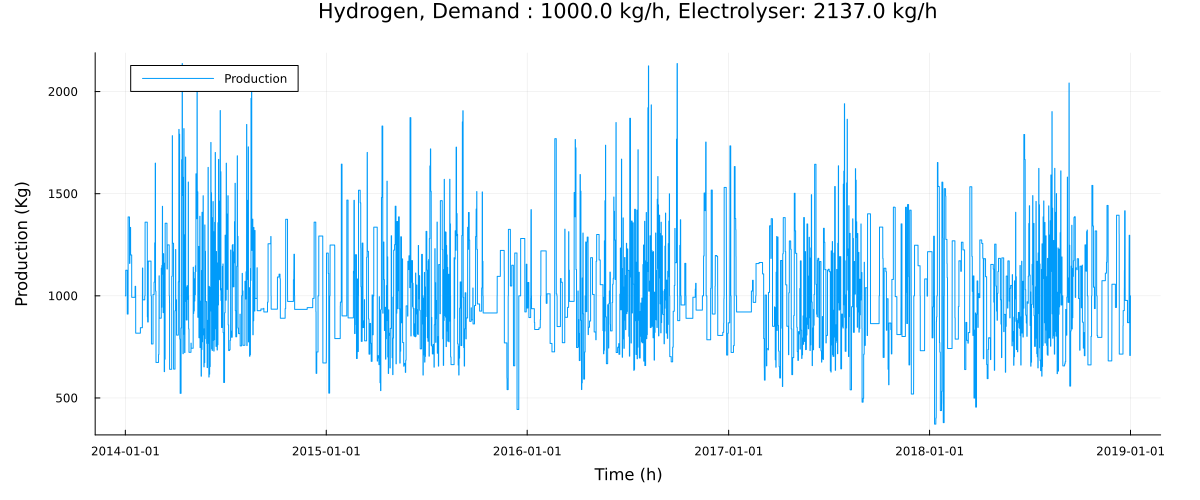

In [14]:
prod4

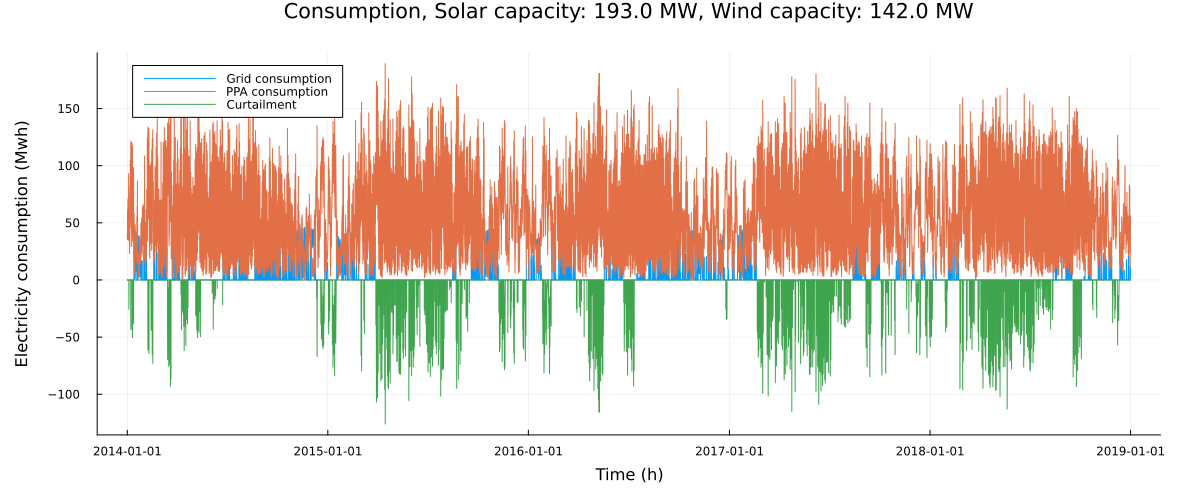

In [15]:
cons4

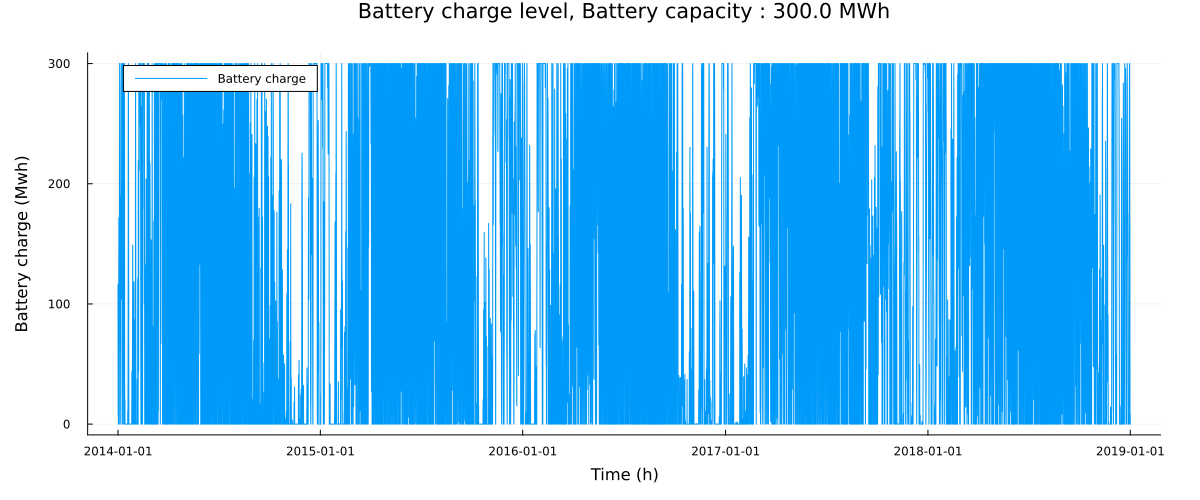

In [26]:
savefig(bat4, "plots/sizing_bat.png")
bat4

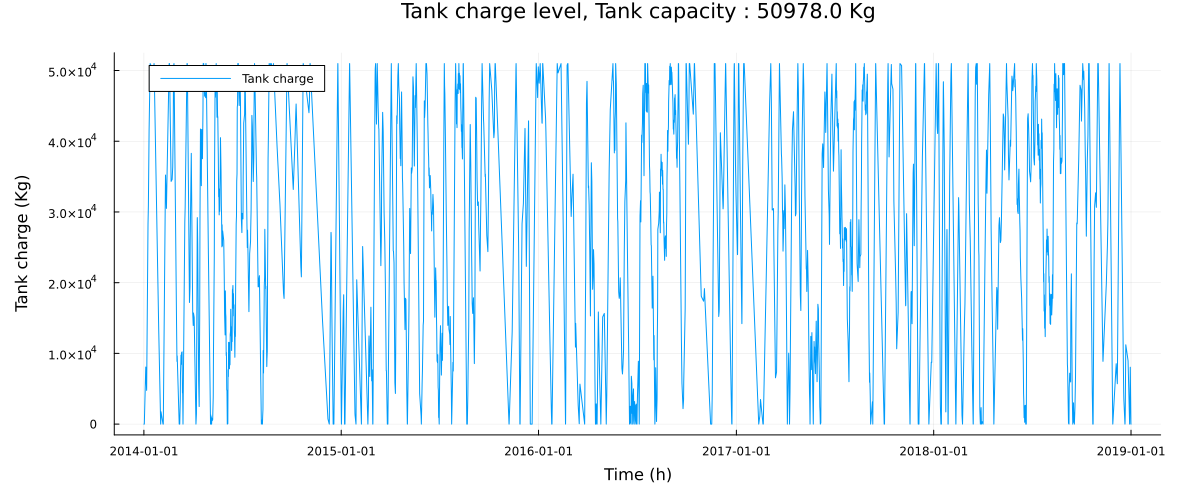

In [27]:
savefig(tank4, "plots/sizing_tank.png")
tank4